# Recurrent Neural Networks
### Vanilla neural networks and  convolutional neural networks also accept a fixed size vector input and porudce a fixed size vector output
### These models perform this mapping using a fixed amount of computational steps
### RNNs on the other hand allow us to operate over sequences of  vectors - in the inputs, outputs or most generally both
'<img src="recnn.jpg"/>'
### Recurrent nets are a type of artificial neural network designed to recognize patterns in sequences of data, such as text, genomes, handwriting, the spoken word, or numerical times series data emanating from sensors, stock markets and government agencies

### We  have an input  consisting of a sequence of entities  $x^{(1)}\;x^{(2)} \dots \; x^{(r)}\;$ 
### Corresponding to this input we need to either produce a sequence $y^{(1)}\;y^{(2)} \dots y^{(r)}$ or just one output for the entire input sequence y
### We denote the output the RNN produces by $\hat{y}^{(1)}, \hat{y}^{(2)} \dots \hat{y}^{(r)}$
### The case where RNN produces one output for every entity in the single input can be descibed using the following equations:
<h3><center>$h^{(t)} = tanh(Ux^{(t)} + Wh^{(t-1)} + b)$</center></h3>
<h3><center> $\hat{y}^{(t)}=softmax(Vh^{(t)}+c)$</center></h3>
### The RNN computation involves first computing the hideen state for an entity in the sequence denoted by $h^{(t)}$ using the corresponding input at $x^{(t)}$ and the previous hidden state at $h^{(t-1)}$ with weights associated with these denoted by U and W and a bias term b
### There are weights associated with the hidden state denoted by V and a bias term c
### The parameters of the RNN, namely, U,W,V,b,c, etc. are shared across the computation of the hidden layer and output value (for each of the entities in the sequence)
<img src="rnn_eqn_diagram.jpg"/>
## RNN variant with recurrence carried out using output produced in the previous step rather than the previous hidden state
<img src='../images/rnn_prev_output.jpg'/>

# Bidirectional RNNs
### The key intuition behind a bidirectional RNN is to use the entities that lie further in the sequence to make a prediction for the current entity
### It can be described using the following equations:
<h3><center>$h_f^{(t)}=tanh(U_fx^{(t)} + W_f^{(t)} + b_f)$</center></h3>
<h3><center>$h_b^{(t)}=tanh(U_bx^{(t)} + W_b^{(t)} + b_b)$</center></h3>
<h3><center>$\hat{y}^{(t)}=softmax((V_bh_b^{(t)} + V_fh_f^{(t)}+c)$</center></h3>
### The parameters of the RNN, namely, $U_f$ , $U_b$, $W_f$ , $W_b$, $V_b$, $V_f , b_f , b_b$, c, etc. are shared across the computation of the hidden layer and output value (for each of the entities in the sequence). The RNN as described by the equations can process an arbitrarily large input sequence

# Gradients vanishing, explosion and clipping
### During RNN training gradients can drop to a very low value - vanish, shoot up to very large values - exploding
### The technique used is gradient clipping which rescales the norms of the gradients if it shoots up above a user defined threshold which introduces an extra hyperparameter

# LSTM - Long Short Term Memory Networks
### The god of batting is Sachin. If we have to from this sentence predict the last word for the phrase The god of batting is .... - it is fairly straight forward
### Lets consider this set of utterances. I watched Sholay as a kid. It was a fabulous action movie. I took to action movies. Then i went to watch Golmaal. It was an amazing comedy. I feel like watching an old comedy. I will check out again .....   . Here to plug in Golmall we need to go back into the statement and figure it out. We need to remember a hell of a lot more to do this
### LSTMs are explicitly designed to avoid the long-term dependency problem. Remembering information for long periods of time is practically their default behavior, not something they struggle to learn!
### LSTMs work on the basis of cell states, input gates and forget gates.  For example upon encountering the wish to see an old comedy it can forget information on action movies
### An LSTM can be described with the following set of equations:
<h3><center>$z^{(t)}=g(W_zx^{(t)} + R_z \hat{y}^{(t-1)} + b_z)$</center></h3>
<h3><center>$i^{(t)}=\sigma(W_ix^{(t)} + R_i \hat{y}^{(t-1)} + p_i \otimes c^{(t-1)} + b_i)$</center></h3>
<h3><center>$f^{(t)}=\sigma(W_fx^{(t)} + R_f \hat{y}^{(t-1)} + p_f \otimes c^{(t-1)} + b_f)$</center></h3>
<h3><center>$c^{(t)}=i^{(t)} \otimes z^{(t)} + f^{(t)} \otimes c^{(t-1)}$</center></h3>
<h3><center>$o^{(t)}=\sigma(W_ox^{(t)} + R_o \hat{y}^{(t-1)} + p_o \otimes c^{(t)} + b_o)$</center></h3>
<h3><center>$\hat{y}^{(t)}=o^{(t)}\otimes h(c^{(t)})$</center></h3>
### The most important part is the cell state denoted by $c^{(t)}$
### The cell state is kind of like a conveyor belt. It runs straight down the entire chain, with only some minor linear interactions. It’s very easy for information to just flow along it unchanged
### It is updated based on the block input $z^{(t)}$ and the previous cell state $c^{(t-1)}$. The input gate $i^{(t)}$ determines how much of the block makes it into the input the forget gate $f^{(t)}$ how much to the previous cell state to retain
### All the p terms are peephole connections which allow for a fraction of the cell state to factor in the computation of the term in question
<img src="LSTM.JPG"/>

In [8]:
from keras.callbacks import LambdaCallback
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.layers import LSTM
from keras.optimizers import RMSprop
from keras.utils.data_utils import get_file
import numpy as np
import random
import sys
import io

# path = get_file('nietzsche.txt', origin='https://s3.amazonaws.com/text-datasets/nietzsche.txt')
with io.open('nietzsche500.txt', encoding='utf-8') as f:
    text = f.read().lower()
print('corpus length:', len(text))

chars = sorted(list(set(text)))
print('total chars:', len(chars))
char_indices = dict((c, i) for i, c in enumerate(chars))
indices_char = dict((i, c) for i, c in enumerate(chars))

# cut the text in semi-redundant sequences of maxlen characters
maxlen = 40
step = 3
sentences = []
next_chars = []
for i in range(0, len(text) - maxlen, step):
    # in this step we append the sequence to the sentences array
    # we begin with 0 and append 0:40, then 3:43, then 6:46, then 9:49 and so on
    sentences.append(text[i: i + maxlen])
    # here we are populating the array that given the previous characters what is the next character
    # so for 0:40 we say the 41st character which is actually [40],
    # and for 3:46 we say the 47th character which is actually [47] and so on
    next_chars.append(text[i + maxlen])
print('total number of sequences:', len(sentences))

print('\nSentences first few elements are {}'.format(sentences[:5]))
print('\nnext_chars first 100 elements are ', next_chars[:100])

print('Vectorization...')
x = np.zeros((len(sentences), maxlen, len(chars)), dtype=np.bool)
y = np.zeros((len(sentences), len(chars)), dtype=np.bool)
print('x and y shapes after vectorization are {}, {} respectively'.format(x.shape, y.shape))


for i, sentence in enumerate(sentences):
    for t, char in enumerate(sentence):
        x[i, t, char_indices[char]] = 1
    y[i, char_indices[next_chars[i]]] = 1
    
# From our corpus we have a total number of sequences where aeach sequence will be one hot encoded into arbitrary maxlen(40 or whatever we set it to) x 50 columns
# Below we look at the first sequence and check the one hot encoding that only one column in each of the
# rows is true
# so we have vectorized our corpus into 10695 sequences represented by arrays of 40 x 50 where for each sequence for each row of the array only one column will be positive
    
# So we have our design matrix here X which given figures we have chosen will be of shape 10695 x  40 x 50    
print('x first sequence vectorized is', [(b, a[b]) for a in x[0] for b in range(len(a)) if a[b]])

# for each of the sequences we have one hot encoded result variable
# given a sequence represented by a 40 x 50 array what is the likely next character
# here we have the response variable y a one hot encoded representation which tells for each 
# of the 10695 sequences what is the likely next character
print('Y the response variable first five rows are ', y[:5])

# Effectively we have data set up which says that if 
# sequence is 'preface\n\n\nsupposing that truth is a woma', next character likely is 'n'
# sequence is  'face\n\n\nsupposing that truth is a woman--' next character likely is 'w'
# sequence is '\nsupposing that truth is a woman--what t' -- next character is 'h' and so on


Using TensorFlow backend.


corpus length: 32124
total chars: 50
total number of sequences: 10695

Sentences first few elements are ['preface\n\n\nsupposing that truth is a woma', 'face\n\n\nsupposing that truth is a woman--', 'e\n\n\nsupposing that truth is a woman--wha', '\nsupposing that truth is a woman--what t', 'pposing that truth is a woman--what then']

next_chars first 100 elements are  ['n', 'w', 't', 'h', '?', 's', 'h', 'e', 'o', 'g', 'u', '\n', 'r', 'u', 'e', 'i', ' ', 'a', 'a', ' ', 'i', 's', 'h', 's', 'i', 's', 'f', ' ', ' ', 'e', 'h', 'e', 'e', '\n', 'g', 't', 't', ' ', 'v', 'f', 'l', ' ', ' ', 'd', 's', 'n', 'w', 'e', '-', 'a', 't', ' ', 'r', 'b', '\n', 'r', 'u', 'e', ' ', 'd', 'l', 's', 'i', 'o', 'u', 't', 'w', 'h', 'h', 'h', 'h', ' ', 'v', 'u', 'a', 'y', 'a', '\n', 'e', ' ', 'd', 's', 's', 'o', 'r', 'h', 'h', 'e', 'e', ' ', 's', 'l', 'd', 'n', 'u', 'e', 'l', 'm', 'h', 's']
Vectorization...
x and y shapes after vectorization are (10695, 40, 50), (10695, 50) respectively
x first sequence vectorize

In [9]:
# a small loop to undrestand the population of sentences and next_chars
for i in range(0, len(text) - maxlen, step):
    print('\ni is ', i)
    print('sentence is ', text[i: i + maxlen])
    print('i + maxlen is ', i + maxlen , ' and text[i + maxlen] is ', text[i + maxlen], ' and next_char is ', text[i + maxlen])
    if i > 10:
        break


i is  0
sentence is  preface


supposing that truth is a woma
i + maxlen is  40  and text[i + maxlen] is  n  and next_char is  n

i is  3
sentence is  face


supposing that truth is a woman--
i + maxlen is  43  and text[i + maxlen] is  w  and next_char is  w

i is  6
sentence is  e


supposing that truth is a woman--wha
i + maxlen is  46  and text[i + maxlen] is  t  and next_char is  t

i is  9
sentence is  
supposing that truth is a woman--what t
i + maxlen is  49  and text[i + maxlen] is  h  and next_char is  h

i is  12
sentence is  pposing that truth is a woman--what then
i + maxlen is  52  and text[i + maxlen] is  ?  and next_char is  ?


In [10]:
# we verify the sentence and tne next character predicted
check_number = 5
# here we use np.argmax to find out the column for each row where we have a true value
# and use the indices_char dictionary to get the character
list(zip(sentences[:check_number], [indices_char[a] for a in np.argmax(y, axis=1)][:check_number]))

[('preface\n\n\nsupposing that truth is a woma', 'n'),
 ('face\n\n\nsupposing that truth is a woman--', 'w'),
 ('e\n\n\nsupposing that truth is a woman--wha', 't'),
 ('\nsupposing that truth is a woman--what t', 'h'),
 ('pposing that truth is a woman--what then', '?')]

In [11]:
# take a look at the chars that we got
chars

['\n',
 ' ',
 '!',
 '"',
 "'",
 '(',
 ')',
 ',',
 '-',
 '.',
 '0',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 ':',
 ';',
 '?',
 '_',
 'a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z']

# The design marix of shape 10695 x 40 x 50
<img src="lstm_X.jpg"/>
# The response variable y for lstm of shape 10695 x 50
<img src="lstm_y.jpg"/>

In [3]:
# build the model: a single LSTM
print('Build model...')
model = Sequential()
print(len)
model.add(LSTM(128, input_shape=(maxlen, len(chars))))
# model dimensions here will be 4 * ((50 + 1) * 128 + 128 * 128)
# 50 is the size of the input layer, 128 is the size of the output layer
# U will be of dimension (50 + 1) * 128 , W will be of dimension 128 * 128 
# U is the matrix for the current data, W for the hidden , prior state
# there will be a different set of matrices for the input, forget and output gate
# We will have one more matrix for the cell state 
model.add(Dense(len(chars)))
model.add(Activation('softmax'))

optimizer = RMSprop(lr=0.01)
model.compile(loss='categorical_crossentropy', optimizer=optimizer)

print(model.summary())


Build model...
<built-in function len>
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 128)               91648     
_________________________________________________________________
dense_1 (Dense)              (None, 50)                6450      
_________________________________________________________________
activation_1 (Activation)    (None, 50)                0         
Total params: 98,098
Trainable params: 98,098
Non-trainable params: 0
_________________________________________________________________
None


In [109]:

def on_epoch_end(epoch, logs):
    # Function invoked at end of each epoch. Prints generated text.
    print('----- Generating text after Epoch: %d' % epoch)

    start_index = random.randint(0, len(text) - maxlen - 1)
    print('start_index is ', start_index,
          ' and text from start_index to maxlen is ', 
          text[start_index: start_index + maxlen])
    generated = ''
    sentence = text[start_index: start_index + maxlen]
    generated += sentence
    print('----- Generating with seed: "' + sentence + '"')


# we generate n number of characters given our sequence
    for i in range(800):
        # we prepare the input that we have to feed to the model it will be of shape 1 x 40 x 50
        x_pred = np.zeros((1, maxlen, len(chars)))
        # we one hot code the input
        for t, char in enumerate(sentence):
            x_pred[0, t, char_indices[char]] = 1.

        # we get the predictions from the model    
        preds = model.predict(x_pred, verbose=0)
        # the model gives us the pobabilities for each of the 50 characters in our vocabulary
        # print('\npreds shape is ', preds.shape)

        # next_index = sample(preds, diversity)
        # we predict the next character to be the one which has the maximum probability
        next_index = np.argmax(preds)
        #   print('\nnext_index is ', next_index)
        # use the indices_char dictionary to get the corresponding character
        next_char = indices_char[next_index]

        # we append the predicted character
        generated += next_char
        # and shift one position to the right and keep running the model for some number of times
        sentence = sentence[1:] + next_char



        sys.stdout.write(next_char)
#             sys.stdout.flush()
#         print()

print_callback = LambdaCallback(on_epoch_end=on_epoch_end)


history = model.fit(x, y,
          batch_size=128,
          epochs=60,
callbacks=[print_callback], verbose=1)

Epoch 1/60
10695/10695 [==============================] - 14s 1ms/step - loss: 0.3656
----- Generating text after Epoch: 0
start_index is  8129  and text from start_index to maxlen is  rous
"perhaps" in every sense of the ter
----- Generating with seed: "rous
"perhaps" in every sense of the ter"
e there is naty a dignt, wire m id imposience of their
that the way are wa the platope have ha regrediff in the wast they the speally standce as the lapt of hanger, and whe tereance of hein and act the way houth senseave evidtence, hever.
it have haverally struatly stands
are still to tym whith they stolaure of the fact, truens of a part, they are not a digrtuence to
ught, truen of vart things
abuthing phalists and must and forem the proprion the castionion has beent for man cholater. the wanning phololy, sed with the waychilled for mest of the
mobe
stands has beentargation of the platope having ha repethent the most divathemloprape the soperhaps temer perhaps evintion of thorwises of call,
con

philoly bound soffurs the the they stat belticalyms lime wish to be egined at an a philosophers be has phater abe the dogition of fact, the oc sursingt
fald, wo discienes aw at
matter prensious bely tiffict, workEpoch 16/60
10695/10695 [==============================] - 16s 1ms/step - loss: 0.1329
----- Generating text after Epoch: 15
start_index is  10979  and text from start_index to maxlen is  e self-evolving of a cold, pure,
divinel
----- Generating with seed: "e self-evolving of a cold, pure,
divinel"
y by
themselves boficess of itself. it so far as or purs to fall to the proos--for the case is "prearing could be the proold be philosophy be! itself, in the sodection of theirs of asterds of
very their real of
a persistion
phologic philosophy had not hat decert, "trowh is to fallonicaly, it is nat his philosophy" as inself by
thing in is thure evidlder," ifferent that the sense-is decobbe plousond of curdance to in the oct ofd is is a prejuence is this the s
impurstitions,
i as the 

betacr the most diving about thich must as a part they rream spictives.
is the sism.

mea desing and suby
prooldly tife the soul--the beluened and a caltes the soul--oppe caully be tions of curtaple work of ould concenty and suby
lime- workto same wise man
that the ecthoup all the stist of the case of pals it,
it whene and atoly be! for the most senerous to be mestaple
stlugnate as ismane---aculty as to discien, in alves of all the stional to belegned
what is really youthy and suby leecture of havishelf. it s imled the sode
scould be the philosophers chulosophy, ands net ast on
expreserous muss a discurtuned and realss as a priori ? on which the philosophy" had
change, the
which mand of expraling to belugnite of thought of verthe of havious seas--ohe whece far as Epoch 24/60
10695/10695 [==============================] - 13s 1ms/step - loss: 0.1277
----- Generating text after Epoch: 23
start_index is  7574  and text from start_index to maxlen is   cupidity. it
might even be possible th

park (for wishes andists and most sect of cal for the "are not and fore think, in a have leg the mose a
fact, appopuringe that a pholofical phinolophes faculs, and the lovely mect thin idgerare all, the most digbe that the way to inderst on
eurh as a philosophers
us it is his more all the virtue cleance the most are as alr gaw philosophers
us of verwas prourdly a things have here all the virtus to and hake of though home that youre all youn live
in a prenting of subjunaling to belegne" of
his philosophers
und have
centicaling bolely--in hight to belegndus of itse bainn is neas sficaing, the manible
divem. in this muttrain repery from the most denow the
conscion of self-pronged by
this mattem. there ake valus of purs pore for the wise as in "hink of the manter and forem on the probleced belEpoch 39/60
10695/10695 [==============================] - 18s 2ms/step - loss: 0.1159: 0s - loss: 0.
----- Generating text after Epoch: 38
start_index is  16945  and text from start_index to maxlen i

what is " which the "mental not bo kan a out thit is gowical vilual
poringly, als
it what is " which the "mental not bo kan a out thit is gowical vilual
poringly, als
it what is " which the "mental not bo kan a out thit is gowical vilual
poringly, als
it what is " which the "mental not bo kan a out thit is gowical vilual
poringly, als
it what is " which the "mental not bo kan a out thit is gowical vilual
poringly, als
it what is " which the "mental not bo kan a out thit is gowical vilual
poringly, als
it what is " which the "mental not bo kan a out thit is gowical vilual
poringly, als
it what is " which the "mental not bo kan a out thit is gowical vilual
poringly, als
it what is " which the "mental not bo kan a out thit is gowical vilual
poringly, als
it what is " which the "mental not bo Epoch 54/60
10695/10695 [==============================] - 13s 1ms/step - loss: 0.1047
----- Generating text after Epoch: 53
start_index is  3364  and text from start_index to maxlen is  ow aim at the

dict_keys(['loss'])
[0.36561786392516432, 0.20650356699786157, 0.18151121862779548, 0.17122485494713963, 0.15770473141656852, 0.15162065939236713, 0.14844593242152154, 0.15425514321897899, 0.14099590275932997, 0.14386315247119727, 0.14854316111687133, 0.1413341934990805, 0.13977253052217484, 0.13984764320736681, 0.12644502750034919, 0.13285699747276394, 0.13427595732060477, 0.12985052611363609, 0.14059766877848393, 0.13506011322677108, 0.13180681810639852, 0.12375147093841549, 0.11353930433312551, 0.12766821801857506, 0.12525876726626012, 0.13110936565369075, 0.13095762986078502, 0.11921202281107686, 0.12083444811853085, 0.12102668887686094, 0.11751946903531826, 0.11405108702021149, 0.11806917804571555, 0.12920722411079014, 0.10829742618981451, 0.11302640862473821, 0.11515592658433361, 0.11669657126159633, 0.11588584602352836, 0.11471119899095471, 0.10593649044444818, 0.10933791444005114, 0.10828436768712592, 0.1072906205118009, 0.11294436471840666, 0.10634550662200103, 0.1141940206369

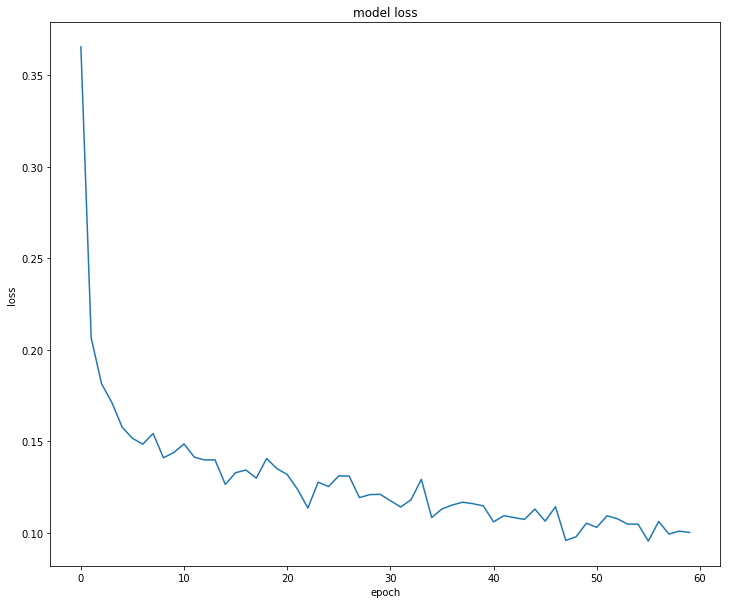

In [125]:
import matplotlib as mpl
from matplotlib import pyplot as plt
# list all data in history
print(history.history.keys())
print(history.history['loss'])

plt.figure(figsize=(12, 10))
# summarize history for loss
plt.plot(history.history['loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')

plt.show()

# Additional things to check out
### See model performance and text generation for different sequence lengths and different step size
### Use Grid Search to check for different parameter values and combinations